In [1]:
import itertools
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import teotil2 as teo

plt.style.use("ggplot")
warnings.simplefilter("ignore")

# TEOTIL2: Nutrient fluxes upstream of Hensfossen

Miljødirektoratet are interested in nutrient inputs upstream of Hensfossen, a little to the north of Hønefoss. Specifically, we are interested in fluxes of total N and P upstream of vannforekomst ID `012-2456-R` (Ådalselva fra Sperillen til Hensfossen; see [here](https://vann-nett.no/portal/#/waterbody/012-2456-R)). Using NVE Atlas, this corresponds to regine ID `012.F31`.

**Update 06.06.2023:** Miljødirektoratet would like to include fluxes from Norske Skogindustrier ASA (Follum Fabrikker). According to our database, this site is located about 5 km downstream from Hensfossen, which corresponds to regine `012.F12`

This notebook focuses on accumulated fluxes (i.e. from the entire upstream area, allowing for retention) from **industry**, **sewage treatment** and **agriculture**.

## 1. User options

In [2]:
# Period of interest
st_yr, end_yr = 1990, 2021

# Parameters of interest
pars = ["tot-n", "tot-p"]

# Regine of interest
reg_id = "012.F12"

# Sources of interest
src_list = ["ind", "agri", "ren", "spr"]

# Accumulated or local values?
stat = "accum"

## 2. Run model

In [3]:
# Run model
df_list = []
for year in range(st_yr, end_yr + 1):
    input_csv = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_input_data/input_data_{year}.csv"
    g = teo.model.run_model(input_csv)
    df = teo.model.model_to_dataframe(g)
    df = df.query("regine == @reg_id")
    df["year"] = year
    df_list.append(df)
df = pd.concat(df_list, axis="rows")

# Combine point and diffuse for agriculture
for par in pars:
    df[f"accum_agri_{par}_tonnes"] = (
        df[f"accum_agri_diff_{par}_tonnes"] + df[f"accum_agri_pt_{par}_tonnes"]
    )
    del df[f"accum_agri_diff_{par}_tonnes"], df[f"accum_agri_pt_{par}_tonnes"]

# Tidy
id_cols = ["regine", "year"]
cols = [col for col in df.columns if col.startswith(stat)]
df = df[id_cols + cols]
df.columns = [col.replace("accum_", "") for col in df.columns]

# Get cols of interest
cols = [f"{src}_{par}_tonnes" for src, par in itertools.product(src_list, pars)]
df = df[id_cols + cols]

# Convert to long format
df = df.melt(id_vars=["regine", "year"])
df[["source", "par", "unit"]] = df["variable"].str.split("_", 0, expand=True)
df = df[id_cols + ["source", "par", "value"]]
df.rename({"value": "Accumulated flux (tonnes)"}, inplace=True, axis="columns")

df.head()

,regine,year,source,par,Accumulated flux (tonnes)
0,012.F12,1990,ind,tot-n,45.5
1,012.F12,1991,ind,tot-n,40.0
2,012.F12,1992,ind,tot-n,27.0
3,012.F12,1993,ind,tot-n,35.0
4,012.F12,1994,ind,tot-n,35.0


## 3. Explore results

On the plots and tables below:

 * `ind` corresponds to **industry**
 * `ren` corresponds to **renseanlegg** (i.e. "large" sewage treatment plants > 50 p.e.)
 * `spr` corresponds to **spredt** ("small" sewage treatment plants ≤ 50 p.e., including septic tanks)
 * `agri` corresponds to **agriculture** (both point and diffuse sources)
 

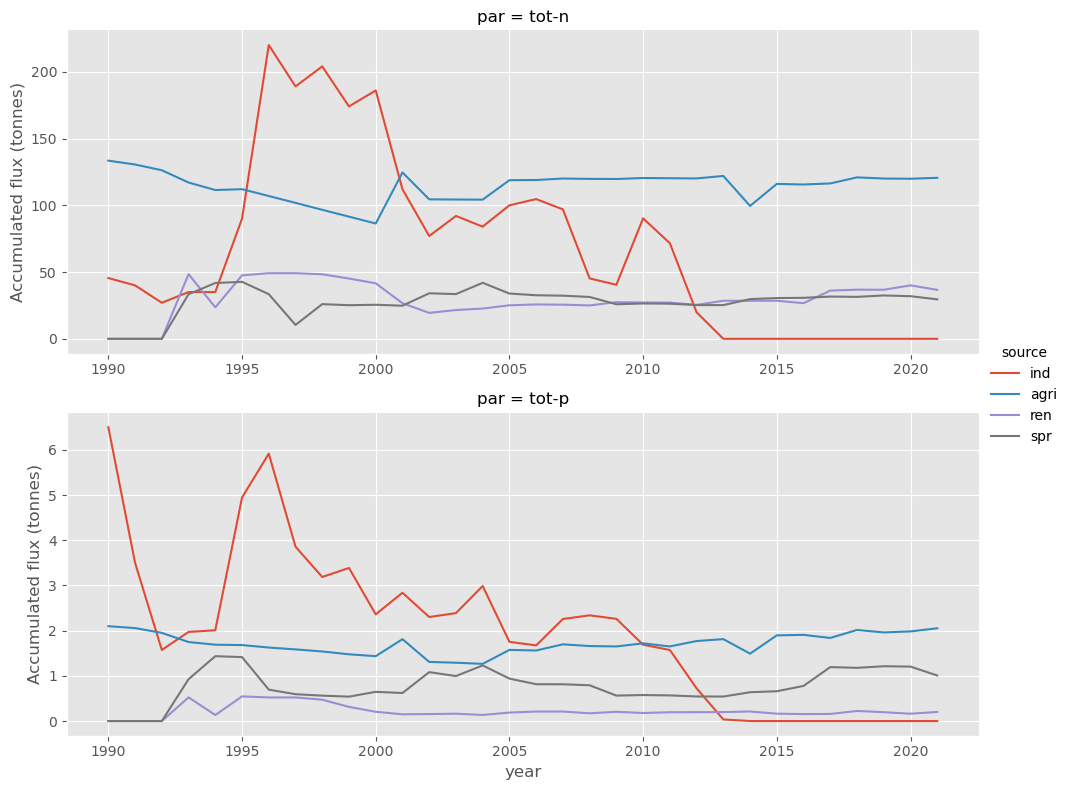

In [4]:
sn.relplot(
    data=df,
    x="year",
    y="Accumulated flux (tonnes)",
    hue="source",
    row="par",
    kind="line",
    height=4,
    aspect=2.5,
    facet_kws={"sharey": False, "sharex": False},
)

In [5]:
# Calculate mean annual fluxes by source over previous decade
df.query("year > 2011").groupby(["par", "source"]).mean()[
    ["Accumulated flux (tonnes)"]
].round(2)

Accumulated flux (tonnes)
par   source                           
tot-n agri                       117.08
      ind                          1.99
      ren                         32.39
      spr                         29.84
tot-p agri                         1.87
      ind                          0.08
      ren                          0.19
      spr                          0.90

## 4. Summary

For the period from 2012 to 2021, typical **annual nutrient fluxes** for the area upstream of regine `012.F12` are:

 * About 120 tonnes of total N and 2 tonnes of total P from agriculture
 
 * About 30 tonnes of total N and 0.2 tonnes of total P from "large" sewage treatment
 
 * About 30 tonnes of total N and one tonne of total P from "small" sewage treatment
 
 * About 2 tonnes of total N and 0.1 tonnes of total P from industry
 
Note that these figures are *only* for industry, sewage treatment and agriculture (including retention in the catchment upstream).